In [ ]:
# Forcing autoreload of modules so restart is not required
%load_ext autoreload
%autoreload 2

import os

os.chdir("../../")


print("Current Working Directory:  ", os.getcwd())

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
X_train = pd.read_csv('./data/processed/NSL_KDD/multi_class/X_train.csv',low_memory=False)
Y_train = pd.read_csv('./data/processed/NSL_KDD/multi_class/Y_train.csv',low_memory=False)


X_test = pd.read_csv('./data/processed/NSL_KDD/multi_class/X_test.csv',low_memory=False)
Y_test = pd.read_csv('./data/processed/NSL_KDD/multi_class/Y_test.csv',low_memory=False)

In [4]:
Y_test['class'].value_counts()

class
0    9711
2    7092
1    5741
Name: count, dtype: int64

In [ ]:
class VAEClassifier(nn.Module):
	def __init__(self, input_dim=123, hidden_dim=64, latent_dim=32, num_classes=3):
		super(VAEClassifier, self).__init__()
		
		# Encoder
		self.fc1 = nn.Linear(input_dim, hidden_dim)
		self.fc_mu = nn.Linear(hidden_dim, latent_dim)
		self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
		
		# Decoder
		self.decoder = nn.Sequential(
			nn.Linear(latent_dim, hidden_dim),
			nn.ReLU(),
			nn.Linear(hidden_dim, input_dim),
			nn.Sigmoid()
		)
		
		# Classifier head
		self.classifier = nn.Sequential(
			nn.Linear(latent_dim, hidden_dim),
			nn.ReLU(),
			nn.Linear(hidden_dim, num_classes)
		)

	def encode(self, x):
		h = F.relu(self.fc1(x))
		mu = self.fc_mu(h)
		logvar = self.fc_logvar(h)
		return mu, logvar

	def reparameterize(self, mu, logvar):
		std = torch.exp(0.5 * logvar)
		eps = torch.randn_like(std)
		return mu + eps * std

	def decode(self, z):
		return self.decoder(z)

	def forward(self, x):
		mu, logvar = self.encode(x)
		z = self.reparameterize(mu, logvar)
		x_recon = self.decode(z)
		class_logits = self.classifier(z)
		return x_recon, class_logits, mu, logvar


In [ ]:
def vae_loss_function(x_recon, x, mu, logvar):
	# Reconstruction loss
	recon_loss = F.mse_loss(x_recon, x, reduction='mean')
	
	# KL divergence
	kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
	
	return recon_loss + kl_div


In [ ]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.long).squeeze()
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.long).squeeze()

In [8]:
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

In [ ]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAEClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(50):
	model.train()
	running_loss = 0.0
	for inputs, labels in train_loader:
		inputs = inputs.to(device).float()
		labels = labels.to(device).squeeze().long()

		x_recon, logits, mu, logvar = model(inputs)

		class_loss = criterion(logits, labels)
		vae_loss = vae_loss_function(x_recon, inputs, mu, logvar)
		loss = class_loss + vae_loss

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
		running_loss += loss.item()

	print(f"Epoch [{epoch+1}/{50}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/50], Loss: 0.5301
Epoch [2/50], Loss: 0.4158
Epoch [3/50], Loss: 0.3704
Epoch [4/50], Loss: 0.3575
Epoch [5/50], Loss: 0.3509
Epoch [6/50], Loss: 0.3460
Epoch [7/50], Loss: 0.3459
Epoch [8/50], Loss: 0.3413
Epoch [9/50], Loss: 0.3402
Epoch [10/50], Loss: 0.3378
Epoch [11/50], Loss: 0.3361
Epoch [12/50], Loss: 0.3348
Epoch [13/50], Loss: 0.3337
Epoch [14/50], Loss: 0.3328
Epoch [15/50], Loss: 0.5531
Epoch [16/50], Loss: 0.3310
Epoch [17/50], Loss: 0.3310
Epoch [18/50], Loss: 0.3313
Epoch [19/50], Loss: 0.3298
Epoch [20/50], Loss: 0.3286
Epoch [21/50], Loss: 0.3289
Epoch [22/50], Loss: 0.3288
Epoch [23/50], Loss: 0.3279
Epoch [24/50], Loss: 0.3280
Epoch [25/50], Loss: 0.3288
Epoch [26/50], Loss: 0.3271
Epoch [27/50], Loss: 0.3272
Epoch [28/50], Loss: 0.3262
Epoch [29/50], Loss: 0.3318
Epoch [30/50], Loss: 0.3265
Epoch [31/50], Loss: 0.3272
Epoch [32/50], Loss: 0.5865
Epoch [33/50], Loss: 0.3272
Epoch [34/50], Loss: 0.3259
Epoch [35/50], Loss: 0.3266
Epoch [36/50], Loss: 0.3265
E

In [ ]:
from sklearn.metrics import classification_report
from tabulate import tabulate

def evaluate(model, test_loader):
	model.eval()
	all_preds = []
	all_labels = []
	with torch.no_grad():
		for inputs, labels in test_loader:
			inputs, labels = inputs.to(device).float(), labels.to(device).squeeze().long()
			_, outputs, _, _ = model(inputs)
			_, predicted = torch.max(outputs.data, 1)
			all_preds.extend(predicted.cpu().numpy())
			all_labels.extend(labels.cpu().numpy())
	accuracy = 100 * sum([1 for p, l in zip(all_preds, all_labels) if p == l]) / len(all_labels)
	report = classification_report(all_labels, all_preds, target_names=['0', '1','2'], output_dict=True)

	headers = ['precision', 'recall', 'f1-score', 'support']
	table_data = []

	for label in ['0', '1','2']:
		row = [f"{report[label][metric]:.2f}" for metric in headers[:-1]]
		row.append(int(report[label]['support']))
		table_data.append([label] + row)

	table_data.append(['accuracy', '', '', f"{report['accuracy']:.2f}", len(all_labels)])
	table_data.append(['macro avg'] + [f"{report['macro avg'][metric]:.2f}" for metric in headers[:-1]] + [int(report['macro avg']['support'])])
	table_data.append(['weighted avg'] + [f"{report['weighted avg'][metric]:.2f}" for metric in headers[:-1]] + [int(report['weighted avg']['support'])])

	print(f"Test Accuracy: {accuracy/100:.4f}")
	print("Classification Report:")
	print(tabulate(table_data, headers=[''] + headers, tablefmt='grid', floatfmt='.2f'))

	report = classification_report(all_labels, all_preds, target_names=['0', '1','2'], output_dict=True)
	return report

Test Accuracy: 0.7893
Classification Report:
+--------------+-------------+----------+------------+-----------+
|              | precision   | recall   |   f1-score |   support |
+==============+=============+==========+============+===========+
| 0            | 0.74        | 0.92     |       0.82 |      9711 |
+--------------+-------------+----------+------------+-----------+
| 1            | 0.85        | 0.99     |       0.91 |      5741 |
+--------------+-------------+----------+------------+-----------+
| 2            | 0.84        | 0.44     |       0.58 |      7092 |
+--------------+-------------+----------+------------+-----------+
| accuracy     |             |          |       0.79 |     22544 |
+--------------+-------------+----------+------------+-----------+
| macro avg    | 0.81        | 0.79     |       0.77 |     22544 |
+--------------+-------------+----------+------------+-----------+
| weighted avg | 0.80        | 0.79     |       0.77 |     22544 |
+--------------+-

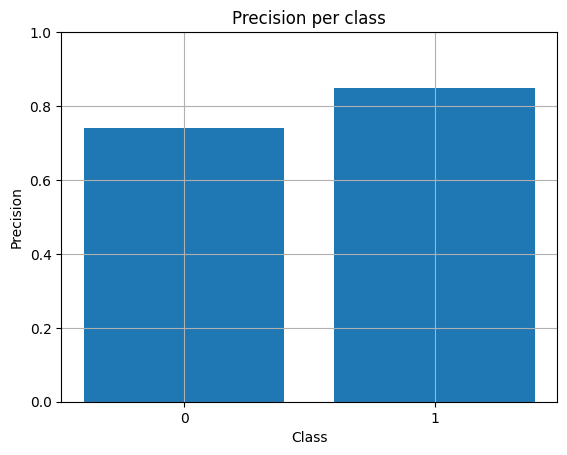

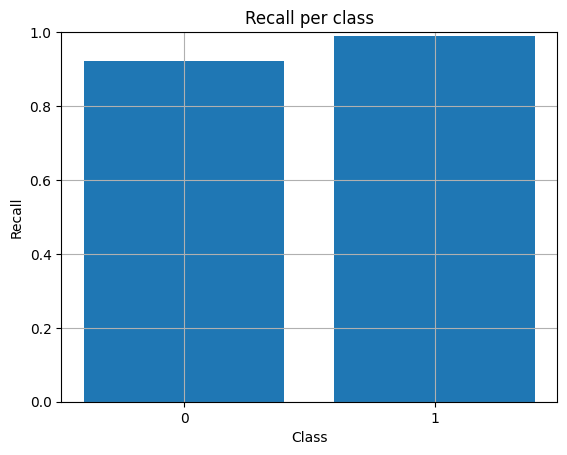

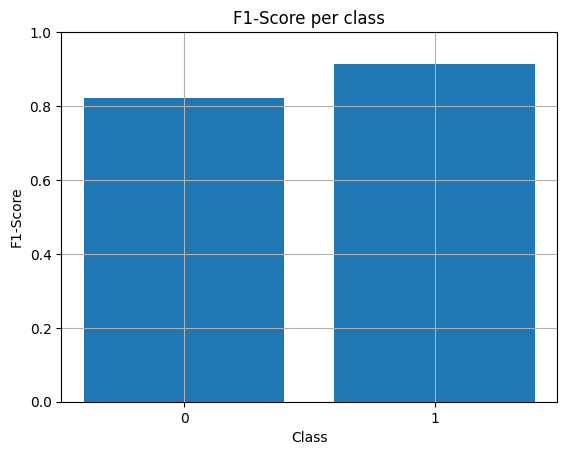

In [ ]:
report = evaluate(model, test_loader)
metrics = ['precision', 'recall', 'f1-score']
classes = ['0', '1']

for metric in metrics:
	values = [report[cls][metric] for cls in classes]
	plt.bar(classes, values)
	plt.ylim(0, 1)
	plt.title(f"{metric.title()} per class")
	plt.xlabel("Class")
	plt.ylabel(metric.title())
	plt.grid(True)
	plt.show()